In [38]:
import numpy as np
import pandas as pd
import utils

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

from scipy.stats import pearsonr, spearmanr, kendalltau
import stat_testing as stattest
from scipy.stats import mannwhitneyu

# To make pretty plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

%matplotlib inline

# Model training

### Load training data

In [2]:
df_train = pd.read_csv("../data/mimic-ft98-clustered-S0-train.csv")
df_train.drop(columns=["starttime", "endtime"], inplace=True)
df_train = df_train.loc[:, df_train.apply(pd.Series.nunique) != 1]

label = "log_duration"

print(df_train.shape)
df_train.head()

(10121, 107)


,stay_id,admission_location,insurance,language,ethnicity,marital_status,gender,age,hours_in_hosp_before_intubation,weight,...,acidbase_score,gcs_score,duration,log_duration,over72h,alive96h,pc1,pc2,pc3,cluster
0,38910812,EMERGENCY ROOM,Other,ENGLISH,UNKNOWN,SINGLE,M,56,17,77.0,...,6.0,48.0,75.033333,4.317932,1,0,60.593486,-5.996556,-2.941236,4
1,38388229,EMERGENCY ROOM,Other,ENGLISH,BLACK/AFRICAN AMERICAN,MARRIED,M,81,45,95.5,...,3.0,33.0,213.633333,5.364261,1,1,-0.342315,-19.286560,3.687725,3
2,31753166,TRANSFER FROM HOSPITAL,Medicare,ENGLISH,WHITE,MARRIED,M,91,73,79.5,...,2.0,24.0,90.416667,4.504429,1,1,7.868908,-4.134309,-5.318351,3
3,30003299,EMERGENCY ROOM,Other,ENGLISH,WHITE,SINGLE,M,26,1,120.0,...,12.0,15.0,154.183333,5.038142,1,1,-18.294562,-7.291070,3.911806,2
4,31166711,EMERGENCY ROOM,Other,ENGLISH,WHITE,SINGLE,M,42,77,97.6,...,12.0,3.0,420.283333,6.040929,1,1,19.069108,25.241420,6.178101,2


In [3]:
df_test = pd.read_csv("../data/mimic-ft98-clustered-S0-test.csv")
df_test.drop(columns=["starttime", "endtime"], inplace=True)
print(df_test.shape)
df_test.head()

(2531, 107)


,stay_id,admission_location,insurance,language,ethnicity,marital_status,gender,age,hours_in_hosp_before_intubation,weight,...,acidbase_score,gcs_score,duration,log_duration,over72h,alive96h,pc1,pc2,pc3,cluster
0,39361378,EMERGENCY ROOM,Other,ENGLISH,UNKNOWN,SINGLE,F,35,2,80.0,...,5.0,48.0,128.750000,4.857873,1,1,47.974668,-12.868124,4.931839,4
1,30754300,TRANSFER FROM HOSPITAL,Medicare,ENGLISH,WHITE,MARRIED,M,74,0,127.0,...,12.0,24.0,455.433333,6.121249,1,1,28.559290,6.192426,6.167873,3
2,31375344,TRANSFER FROM HOSPITAL,Medicare,ENGLISH,UNKNOWN,DIVORCED,M,69,16,70.0,...,2.0,0.0,24.466667,3.197312,0,1,-27.826342,6.293059,-1.844269,1
3,31604434,EMERGENCY ROOM,Medicaid,ENGLISH,OTHER,SINGLE,M,38,2,130.0,...,3.0,15.0,201.216667,5.304382,1,1,0.304676,3.200793,-12.423412,2
4,38669252,EMERGENCY ROOM,Medicare,ENGLISH,BLACK/AFRICAN AMERICAN,MARRIED,F,42,52,58.7,...,NaN,15.0,30.366667,3.413346,0,1,16.774853,10.935837,-5.808469,2


### Train the model

In [4]:
selected_features = features = [
    'height', 
    'resp_rate_avg', 
    'temp_avg', 
    'peep_avg', 
    'peep_min',
    'plateau_pressure_max', 
    'plateau_pressure_avg', 
#     'paraplegia',
    'cns',
    'apsiii',
    'acidbase_score',
    'gcs_score',
    'hours_in_hosp_before_intubation',
]


X_train, y_train = utils.get_X_and_y(df_train, features=selected_features, label=label)
print(X_train.shape, y_train.shape)

X_test, y_test = utils.get_X_and_y(df_test, features=selected_features, label=label)
print(X_test.shape, y_test.shape)

(10121, 12) (10121,)
(2531, 12) (2531,)


In [5]:
preprocessor = utils.define_preprocessor(X_train.columns)
reg = GradientBoostingRegressor()

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', reg)])

In [6]:
df_train["y_pred"] = utils.benchmark_cv(pipe, X_train, y_train, head="reg")

________________________________________________________________________________

Model training: 
train time: 10.394s


In [7]:
pipe.fit(X_train, y_train)
df_test["y_pred"] = pipe.predict(X_test)

In [8]:
pearsonr(df_train.log_duration, df_train.y_pred)[0], pearsonr(df_test.log_duration, df_test.y_pred)[0]

(0.5221989636340525, 0.5267961173681072)

### Calculate the error between actual and predicted values

In [9]:
df_train["error"] = df_train.y_pred - df_train.log_duration
df_train["abs_error"] = df_train.error.abs()

df_test["error"] = df_test.y_pred - df_test.log_duration
df_test["abs_error"] = df_test.error.abs()

### Flag 10% of observations with the highest error as outliers

In [10]:
df = pd.concat([df_train, df_test], axis=0)
df.reset_index(inplace=True, drop=True)
df.shape

(12652, 110)

In [11]:
e = df.abs_error.quantile(0.9)
df["outlier"] = np.where(df.abs_error > e, 1, 0)
df.outlier.value_counts()

0    11386
1     1266
Name: outlier, dtype: int64

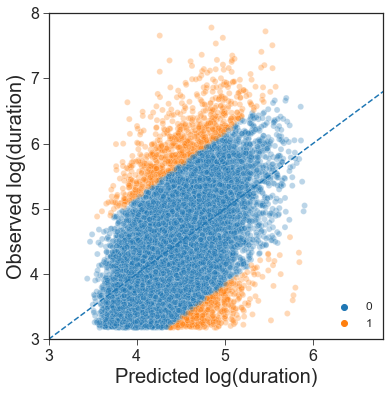

In [12]:
plt.rcParams['figure.figsize'] = (6, 6)
sns.lineplot(x=[3, 8], y=[3, 8], linestyle="--");
sns.scatterplot(x="y_pred", y="log_duration", hue="outlier", data=df, alpha=0.3);
plt.xlabel("Predicted log(duration)");
plt.ylabel("Observed log(duration)");
plt.xlim([3,6.8]);
plt.ylim([3,8]);
plt.legend(fontsize=12, loc="lower right");
# plt.savefig('../results/reg outliers mimic.png', bbox_inches='tight', dpi=300)

### Specify if an outlier due to underprediction or overprediction

In [13]:
df.loc[df.error < -e, "outlier"] = -1
df["outlier category"] = df.outlier.astype("category").map({-1: "Underprediction", 
                                                            0: "Good prediction", 
                                                            1: "Overprediction"})

In [67]:
df.outlier.value_counts()

 0    11386
-1      805
 1      461
Name: outlier, dtype: int64

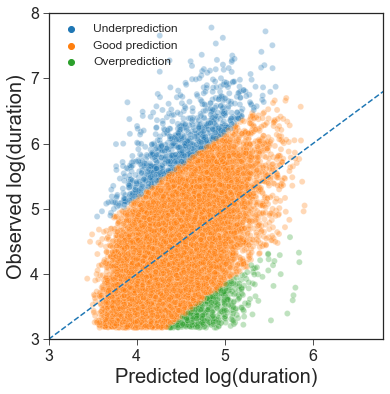

In [14]:
plt.rcParams['figure.figsize'] = (6, 6)
sns.lineplot(x=[3, 8], y=[3, 8], linestyle="--");
sns.scatterplot(x="y_pred", y="log_duration", hue="outlier category", data=df, alpha=0.3);
plt.xlabel("Predicted log(duration)");
plt.ylabel("Observed log(duration)");
plt.xlim([3,6.8]);
plt.ylim([3,8]);
plt.legend(fontsize=12, loc="best");
plt.savefig('../results/reg outliers mimic.png', bbox_inches='tight', dpi=300)

# Compare outliers (using chi2)

### Fill missing values in numeric and categorical variables

In [15]:
cat_features = df.columns[1:7]
num_features = df.columns[7:-13]

len(num_features), len(cat_features)

(92, 6)

In [16]:
df[cat_features].isna().sum()

admission_location       0
insurance                0
language                 0
ethnicity                0
marital_status        1509
gender                   0
dtype: int64

In [17]:
df.marital_status.fillna("TINDER", inplace=True)

### Full list of feature names

In [18]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
onehot.fit(df[cat_features])
onehot.categories_

[array(['AMBULATORY SURGERY TRANSFER', 'CLINIC REFERRAL', 'EMERGENCY ROOM',
        'INFORMATION NOT AVAILABLE', 'INTERNAL TRANSFER TO OR FROM PSYCH',
        'PACU', 'PHYSICIAN REFERRAL', 'PROCEDURE SITE',
        'TRANSFER FROM HOSPITAL', 'TRANSFER FROM SKILLED NURSING FACILITY',
        'WALK-IN/SELF REFERRAL'], dtype=object),
 array(['Medicaid', 'Medicare', 'Other'], dtype=object),
 array(['?', 'ENGLISH'], dtype=object),
 array(['AMERICAN INDIAN/ALASKA NATIVE', 'ASIAN', 'BLACK/AFRICAN AMERICAN',
        'HISPANIC/LATINO', 'OTHER', 'UNABLE TO OBTAIN', 'UNKNOWN', 'WHITE'],
       dtype=object),
 array(['DIVORCED', 'MARRIED', 'SINGLE', 'TINDER', 'WIDOWED'], dtype=object),
 array(['F', 'M'], dtype=object)]

### Define the set of features not used in model training

In [19]:
cat_features_ = [cat.lower() for arr in onehot.categories_ for cat in list(arr)]
feature_names = pd.Index(num_features.tolist() + cat_features_)
len(num_features), len(cat_features_), len(feature_names)

(92, 31, 123)

In [20]:
X, y = utils.get_X_and_y(df, features=None, label=label)
preprocessor = utils.define_preprocessor(X.columns, scale=False)
X = preprocessor.fit_transform(X)
df = pd.concat([df[["stay_id", "outlier", "outlier category"]], pd.DataFrame(X, columns=feature_names)], axis=1)

In [21]:
# df.drop(selected_features, axis=1, inplace=True)

In [22]:
features = df.columns.drop(["stay_id", "outlier", "outlier category"])

### Underprediction vs Good prediction

In [23]:
print("Comparing underpredictions with good predictions: %d records" % 
      df.loc[df.outlier!=1, features].shape[0])

Comparing underpredictions with good predictions: 12191 records


In [24]:
ch2, p = chi2(df.loc[df.outlier!=1, features], df.loc[df.outlier!=1, "outlier"])
chi2_under = pd.DataFrame(zip(features, ch2, p), columns=["feature", "chi2", "pvalue"])
n = (chi2_under.pvalue < 0.01).sum()
print("%d features with p-value < 0.01" % n)
chi2_under.sort_values(by="pvalue").head(n)

33 features with p-value < 0.01


,feature,chi2,pvalue
32,glucose_max,9772.384428,0.000000e+00
1,hours_in_hosp_before_intubation,4105.586557,0.000000e+00
33,glucose_avg,110239.278588,0.000000e+00
91,gcs_score,599.865934,1.790439e-132
13,pao2fio2ratio,107.541492,3.387389e-25
90,acidbase_score,66.732770,3.109232e-16
75,apsiii,64.799200,8.293282e-16
0,age,52.189036,5.040680e-13
62,paraplegia,50.759109,1.044268e-12
88,bilirubin_score,45.105846,1.866673e-11


### Overprediction vs Good prediction

In [25]:
print("Comparing overpredictions with good predictions: %d records" % 
      df.loc[df.outlier!=-1, features].shape[0])

Comparing overpredictions with good predictions: 11847 records


In [26]:
ch2, p = chi2(df.loc[df.outlier!=-1, features], df.loc[df.outlier!=-1, "outlier"])
chi2_over = pd.DataFrame(zip(features, ch2, p), columns=["feature", "chi2", "pvalue"])
n = (chi2_over.pvalue < 0.01).sum()
print("%d features with p-value < 0.01" % n)
chi2_over.sort_values(by="pvalue").head(n)

52 features with p-value < 0.01


,feature,chi2,pvalue
91,gcs_score,5483.059332,0.000000e+00
1,hours_in_hosp_before_intubation,4351.870086,0.000000e+00
75,apsiii,3213.140691,0.000000e+00
32,glucose_max,1469.181763,0.000000e+00
33,glucose_avg,18506.279497,0.000000e+00
90,acidbase_score,472.208550,1.059679e-104
73,cns,282.550464,2.088404e-63
68,SOFA,173.341697,1.378310e-39
80,pao2_aado2_score,165.483340,7.173423e-38
10,lactate_max,116.338145,4.007889e-27


### All three outlier categories

In [27]:
ch2, p = chi2(df[features], df.outlier)
chi2_threeway = pd.DataFrame(zip(features, ch2, p), columns=["feature", "chi2", "pvalue"])
n = (chi2_threeway.pvalue < 0.01).sum()
print("%d features with p-value < 0.01" % n)
chi2_threeway.sort_values(by="pvalue").head(n)

62 features with p-value < 0.01


,feature,chi2,pvalue
1,hours_in_hosp_before_intubation,7937.623365,0.000000
91,gcs_score,5837.063759,0.000000
33,glucose_avg,126360.187353,0.000000
32,glucose_max,10941.023626,0.000000
75,apsiii,3234.828270,0.000000
...,...,...,...
31,spo2_min,12.260855,0.002176
16,heart_rate_min,11.134499,0.003821
2,weight,10.838403,0.004431
14,heart_rate_max,9.659639,0.007988


### Under vs Over

In [68]:
print("Comparing underpredictions with good predictions: %d records" % 
      df.loc[df.outlier!=0, features].shape[0])

Comparing underpredictions with good predictions: 1266 records


In [69]:
ch2, p = chi2(df.loc[df.outlier!=0, features], df.loc[df.outlier!=0, "outlier"])
chi2_ = pd.DataFrame(zip(features, ch2, p), columns=["feature", "chi2", "pvalue"])
n = (chi2_.pvalue < 0.01).sum()
print("%d features with p-value < 0.01" % n)
chi2_.sort_values(by="pvalue").head(n)

56 features with p-value < 0.01


,feature,chi2,pvalue
33,glucose_avg,17800.381218,0.000000e+00
91,gcs_score,1436.644443,0.000000e+00
75,apsiii,1494.690402,0.000000e+00
32,glucose_max,1123.208920,2.982675e-246
80,pao2_aado2_score,169.843230,8.005838e-39
68,SOFA,154.124934,2.174833e-35
1,hours_in_hosp_before_intubation,143.688375,4.156458e-33
90,acidbase_score,130.052436,3.990944e-30
42,fio2_max,111.852548,3.848977e-26
85,bun_score,94.291010,2.723846e-22


### Plot top features from both lists

In [97]:
def show_feature(col, ylabel, plot="barplot", showfliers=True):
    print(df.groupby("outlier category")[col].mean())

    plt.rcParams['figure.figsize'] = (3, 4.5)
    if plot=="barplot":
        sns.barplot(x="outlier category", y=col, data=df);
    else:
        sns.boxplot(x="outlier category", y=col, data=df, showfliers=showfliers)
    plt.xlabel("");
    plt.xticks(rotation=45)
    plt.ylabel(ylabel);
    plt.savefig('../results/outliers ' + col + '.png', bbox_inches='tight', dpi=300)

**Features used in training**

outlier category
Underprediction     98.380124
Good prediction     77.612243
Overprediction     105.414317
Name: hours_in_hosp_before_intubation, dtype: float64


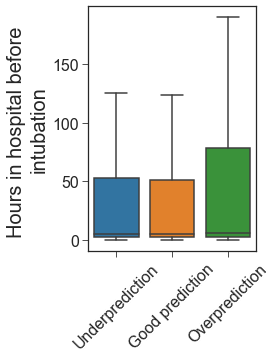

In [99]:
show_feature("hours_in_hosp_before_intubation", "Hours in hospital before \nintubation", plot="boxplot", showfliers=False)

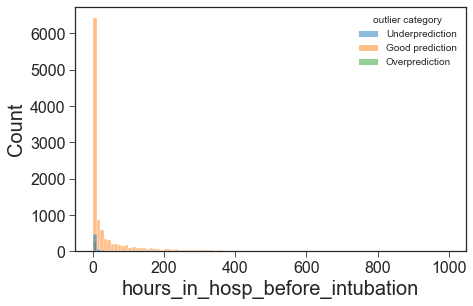

In [50]:
sns.histplot(x="hours_in_hosp_before_intubation", hue="outlier category", 
             data=df[df.hours_in_hosp_before_intubation < 1000], bins=100);

outlier category
Underprediction    20.008696
Good prediction    16.368435
Overprediction     30.843818
Name: gcs_score, dtype: float64


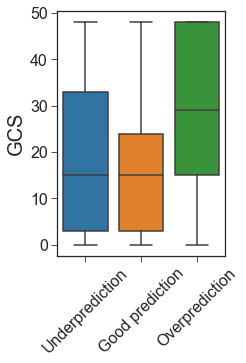

In [100]:
show_feature("gcs_score", "GCS", plot="boxplot")

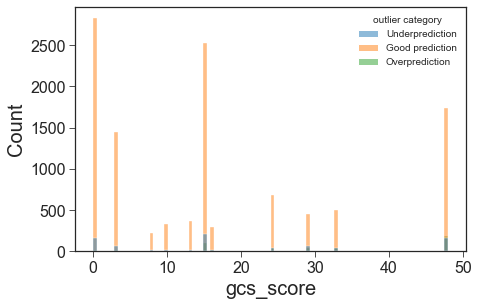

In [57]:
sns.histplot(x="gcs_score", hue="outlier category", 
             data=df, bins=100);

outlier category
Underprediction    67.668323
Good prediction    65.293255
Overprediction     87.195228
Name: apsiii, dtype: float64


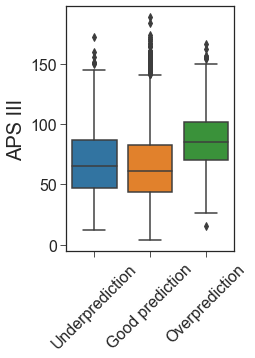

In [130]:
show_feature("apsiii", "APS III",plot="boxplot")

outlier category
Underprediction    6.288199
Good prediction    5.581416
Overprediction     8.041215
Name: acidbase_score, dtype: float64


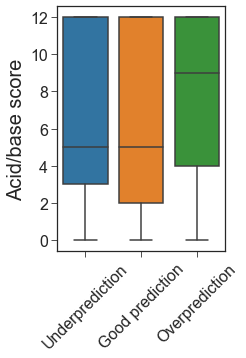

In [103]:
show_feature("acidbase_score", "Acid/base score", plot="boxplot")

outlier category
Underprediction    2.353234
Good prediction    2.013086
Overprediction     3.155844
Name: cns, dtype: float64


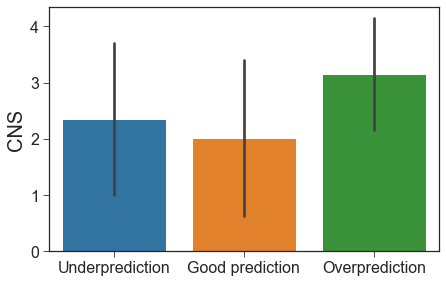

In [40]:
show_feature("cns", "CNS")

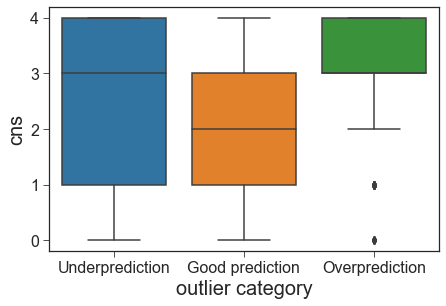

In [41]:
sns.boxplot(y="cns", x="outlier category", data=df);

**Features not used in training**

outlier category
Underprediction    181.370186
Good prediction    236.371289
Overprediction     208.439262
Name: glucose_max, dtype: float64


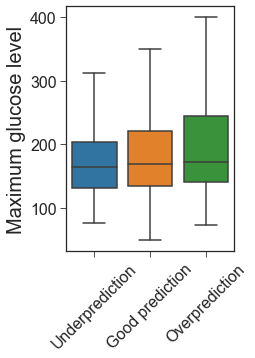

In [98]:
show_feature("glucose_max", "Maximum glucose level", plot="boxplot", showfliers=False)

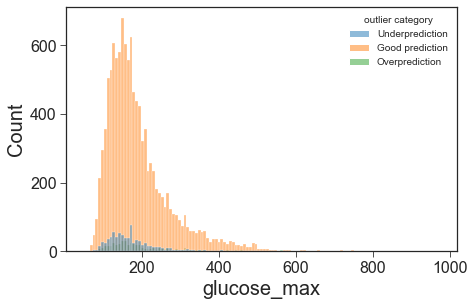

In [61]:
sns.histplot(x="glucose_max", hue="outlier category", data=df[df.glucose_max < 1000]);

outlier category
Underprediction    142.703983
Good prediction    371.214209
Overprediction     247.503980
Name: glucose_avg, dtype: float64


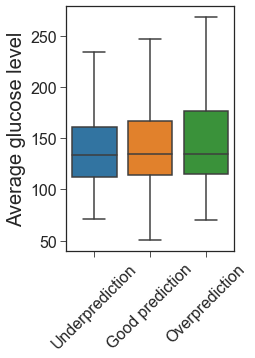

In [108]:
show_feature("glucose_avg", "Average glucose level", plot="boxplot", showfliers=False)

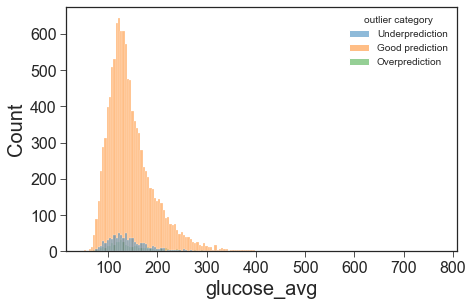

In [66]:
sns.histplot(x="glucose_avg", hue="outlier category", data=df[df.glucose_avg < 1000]);

outlier category
Underprediction    252.588616
Good prediction    246.644258
Overprediction     250.933862
Name: pao2fio2ratio, dtype: float64


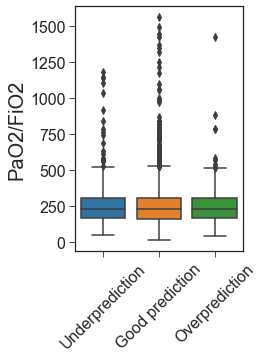

In [119]:
show_feature("pao2fio2ratio", "PaO2/FiO2", plot="boxplot")

outlier category
Underprediction    61.730435
Good prediction    63.833128
Overprediction     65.911063
Name: age, dtype: float64


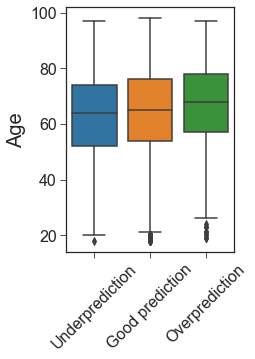

In [106]:
show_feature("age", "Age", plot="boxplot")

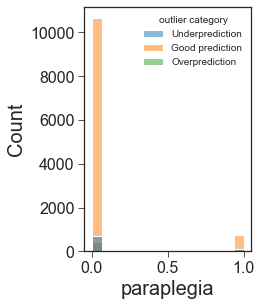

In [113]:
sns.histplot(x="paraplegia", hue="outlier category", data=df);

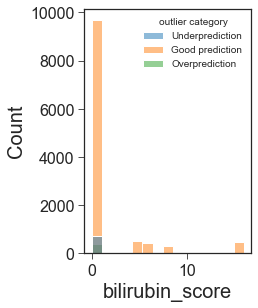

In [117]:
sns.histplot(x="bilirubin_score", hue="outlier category", data=df);

outlier category
Underprediction     7.896894
Good prediction     8.230458
Overprediction     10.032538
Name: SOFA, dtype: float64


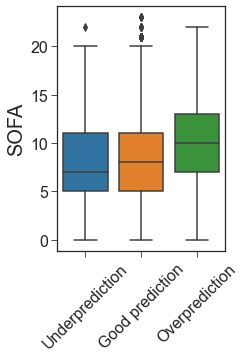

In [120]:
show_feature("SOFA", "SOFA", plot="boxplot")

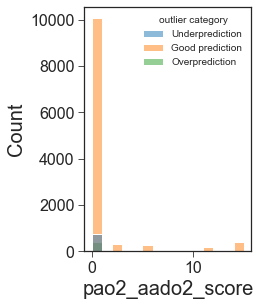

In [123]:
sns.histplot(x="pao2_aado2_score", hue="outlier category", data=df);

outlier category
Underprediction    2.867950
Good prediction    2.902559
Overprediction     3.780694
Name: lactate_max, dtype: float64


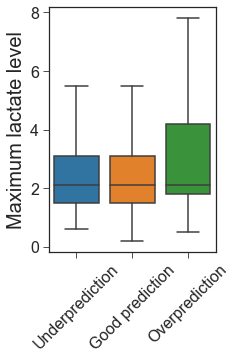

In [129]:
show_feature("lactate_max", "Maximum lactate level", plot="boxplot", showfliers=False)